In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Cropping2D

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.layers import Dense, Activation, Flatten, Dropout, Lambda

Using TensorFlow backend.


In [2]:
def getImage(source_path):
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    BGRImage = cv2.imread(current_path)
    return cv2.cvtColor(BGRImage, cv2.COLOR_BGR2RGB)

steering_correction = 0.25

Number of images:  26212


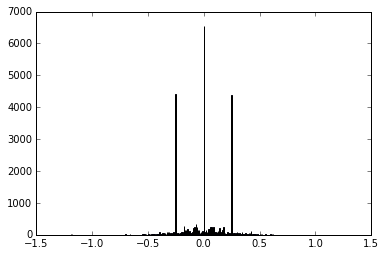

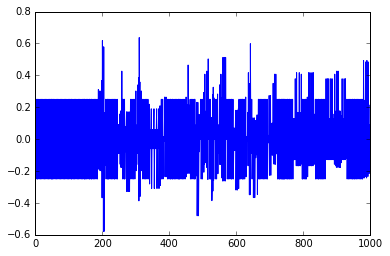

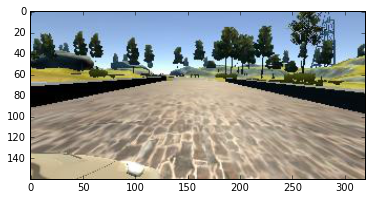

-0.25


In [3]:
#compiling data set without generator
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#print(lines[0])
lines=lines[1:]
#print(lines[0])
images = []
measurements = []

for line in lines:
    steering_center = float(line[3])
    
    #split between not steering and steering
    if(steering_center ==0):
        #no steering
        pUseImage = 0.75
        pIncludeSide = 1.0
        pFlipSide = 0.0
    else:
        #steering
        pUseImage = 1.0
        pIncludeSide = 0.5
        pFlipSide = 0.0
        
    #Include only a percentage of non-steering images
    if(np.random.rand()>(1.0-pUseImage)):
        measurements.append(steering_center)    
                
        center_image = getImage(line[0])
        images.append(center_image)
            
        flipped_steer_center = -steering_center
        measurements.append(flipped_steer_center)
            
        flipped_center_im = np.fliplr(center_image)
        images.append(flipped_center_im)
        
    #Percentage of side images to include
    if(np.random.rand()>(1.0-pIncludeSide)):
        left_image = getImage(line[1])
        right_image = getImage(line[2])

        images.append(left_image)
        images.append(right_image)

        steering_left = (steering_center + steering_correction)
        steering_right = (steering_center - steering_correction)        

        measurements.append(steering_left)
        measurements.append(steering_right)
            
         #Percentage of time to include flipped side image
        if(np.random.rand()>(1.0-pFlipSide)):
            flipped_left_im = np.fliplr(left_image)
            flipped_right_im = np.fliplr(right_image)

            images.append(flipped_left_im)
            images.append(flipped_right_im)

            flipped_steer_left = -steering_center + steering_correction
            flipped_steer_right = -steering_right - steering_correction

            measurements.append(flipped_steer_left)
            measurements.append(flipped_steer_right)
    
X_train = np.array(images)
y_train = np.array(measurements)

print("Number of images: ",len(X_train))

plt.hist(y_train,bins=500)
plt.show()

plt.plot(y_train[0:1000])
plt.show()

plt.imshow(X_train[1])
plt.show()
print(y_train[1])

Sigma =  0.3333333333333333
4086


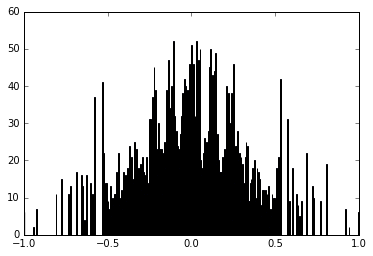

In [5]:
sigma = np.max(np.abs(y_train))/3
print("Sigma = ",sigma)

bufferFactor = 0.001
normalImages=[]
normalSteering=[]

angles = np.random.normal(0,sigma,int(len(y_train)/5))

for angle in angles:
    choices = np.array(0)
    buffer = bufferFactor
    while(choices.size == 0 or choices.any() ==0):
        choices = np.where(np.logical_and(y_train>=(angle-buffer), y_train<=(angle+buffer)))[0]
        buffer+=bufferFactor
    
    pick = np.random.choice(choices)
    normalImages.append(X_train[pick])
    normalSteering.append(y_train[pick])
    
X_train_test = np.array(normalImages)
y_train_test = np.array(normalSteering)

print(len(y_train_test))
plt.hist(y_train_test,bins=400)
plt.show()


Number of images:  20433


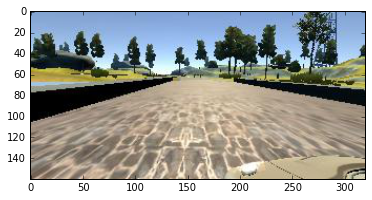

0.25


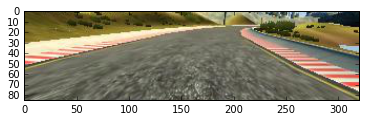

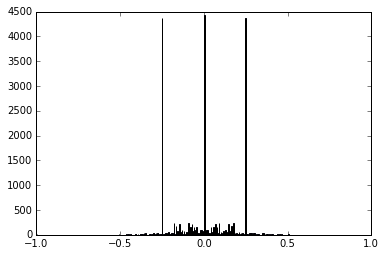

[-0.25  0.25  0.  ]


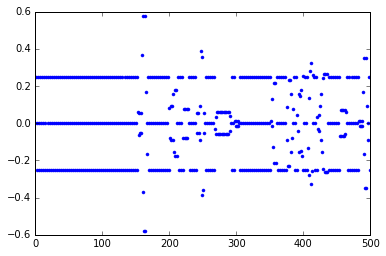

In [6]:
#View Data
print("Number of images: ",len(X_train))

plt.imshow(X_train[4])
plt.show()
print(y_train[4])

image = X_train[5000]
TestImage = image/255
(y,x,z) = TestImage.shape

TestImage = TestImage[50:y-25,0:x]
#Check Preprocessing
plt.imshow(TestImage)
plt.show()

plt.hist(y_train,bins=500)
plt.show()

(values,counts)=np.unique(y_train, return_counts=True)
ind=counts.argsort()[-3:]

print(values[ind])

plt.plot(y_train[0:500],'.')
plt.show()

Number of train_samples =  6428 Number of Validation =  1608


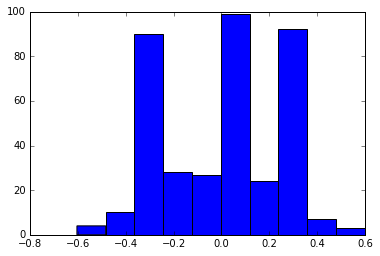

In [7]:
#Generator just taking random samples from data set
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                center_image = getImage(batch_sample[0])
                left_image = getImage(batch_sample[1])
                right_image = getImage(batch_sample[2])

                steering_center = float(batch_sample[3])
                steering_left = (steering_center + steering_correction)
                steering_right = (steering_center - steering_correction)
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)

                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

print("Number of train_samples = ", len(train_samples), "Number of Validation = ", len(validation_samples))
x_train_gen, y_train_gen = (next(train_generator))
plt.hist(y_train_gen)
plt.show()

In [5]:
input = Input(shape=(160, 320, 3))

preProcess1 = Lambda(lambda x: x/255.0 - 0.5)(input)
#preProcess1 = Lambda(lambda x: x/127.5 -1.)(input)

crop1 = Cropping2D(cropping=((50,25),(0,0)), input_shape = (1,160,320))(preProcess1)

conv1 = Convolution2D(64, (7, 7), strides=2)(crop1)
conv1 = MaxPooling2D(pool_size=(3,3), strides=2)(conv1)

conv2 = Convolution2D(192, (3, 3), activation = 'linear', strides=1)(conv1)
conv2 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv2)

#Incesption Layer
Inception1Conv1 = Convolution2D(64, (1, 1), padding='same', activation='linear')(conv2)
Inception1Conv2 = Convolution2D(128, (3, 3), padding='same', activation='linear')(conv2)
Inception1Conv3 = Convolution2D(32, (5, 5), padding='same', activation='linear')(conv2)
Inception1MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(conv2)

Inception1 = concatenate([Inception1Conv1, Inception1Conv2, Inception1Conv3, Inception1MP], axis=3)

drop1 = Dropout(0.4)(Inception1)
act1 = Activation('linear')(drop1)
Flat1=Flatten()(act1)

FCL2 = Dense(10, activation='elu')(Flat1)

output=Dense(1)(FCL2)

model = Model(inputs = input, outputs = output)
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split = 0.2, shuffle=True, epochs = 5)
#model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/3,
#          validation_data=validation_generator, validation_steps=len(validation_samples)/3, epochs=2)

model.summary()

model.save('model.h5')
print("SAVED MODEL")

#So far seems like multiple layers past a single inception have not been any better

#Investigate what goes into the inception

#Seems like the inception with two dense layers, try to get smallest model with 0.009 test and 0.1 validation

#Try edge detecting and gray scalling model and having two networks that converge to 1

#Best is the fully connected layers, may want to try smaller inception with large fully connected layers

#Next tests:
    #make generator faster
    #Uniform Distribution
    #Smaller Batch Size
    #My own generated Data



Train on 20969 samples, validate on 5243 samples
Epoch 1/5
20969/20969 [==============================] - 44s 2ms/step - loss: 0.4901 - val_loss: 0.0324
Epoch 2/5
20969/20969 [==============================] - 45s 2ms/step - loss: 0.0203 - val_loss: 0.0251
Epoch 3/5
20969/20969 [==============================] - 43s 2ms/step - loss: 0.0175 - val_loss: 0.0291
Epoch 4/5
20969/20969 [==============================] - 43s 2ms/step - loss: 0.0161 - val_loss: 0.0203
Epoch 5/5
20969/20969 [==============================] - 44s 2ms/step - loss: 0.0143 - val_loss: 0.0203
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (No